Setup the plot, set the lower and upper bounds for the entire chart, or comment out the set_xlim to auto-scale. Also of inerest is the resolution which is the frequency increment for calculations. Also set the maximum harmonic to display. (should be odd for a square wave) 5th or 7th are probably good values for most cases.

basemag is the "zero" point for magnitudes. normalized values use 0. If using something like dBm or dB relative to RF then choose something a bit below the noise floor. (-180 can work pretty well)

rf_mag is the magnitude of the input signal. Usually 1 for normalized or 0 for dB relative to rf. For dBm, the following are typical definitions. You may want to run calculations for the lowest and highest designed magnitudes when using dBm. Lookup noise floor estimates for your area but somewhere in the S4 region is probably a good guess unless you're very rural.

| S number | Power relative to 50Ω <30 MHz | >30 MHz |
|----------|-------------------------------|---------|
| S1 | -121 dBm | -141 dBm |
| S2 | -115 dBm | -135 dBm |
| S3 | -109 dBm | -129 dBm |
| S4 | -103 dBm | -123 dBm |
| S5 | -97 dBm | -117 dBm |
| S6 | -91 dBm | -111 dBm |
| S7 | -85 dBm | -105 dBm |
| S8 | -79 dBm | -99 dBm |
| S9 | -73 dBm | -93 dBm |

<IPython.core.display.Javascript object>


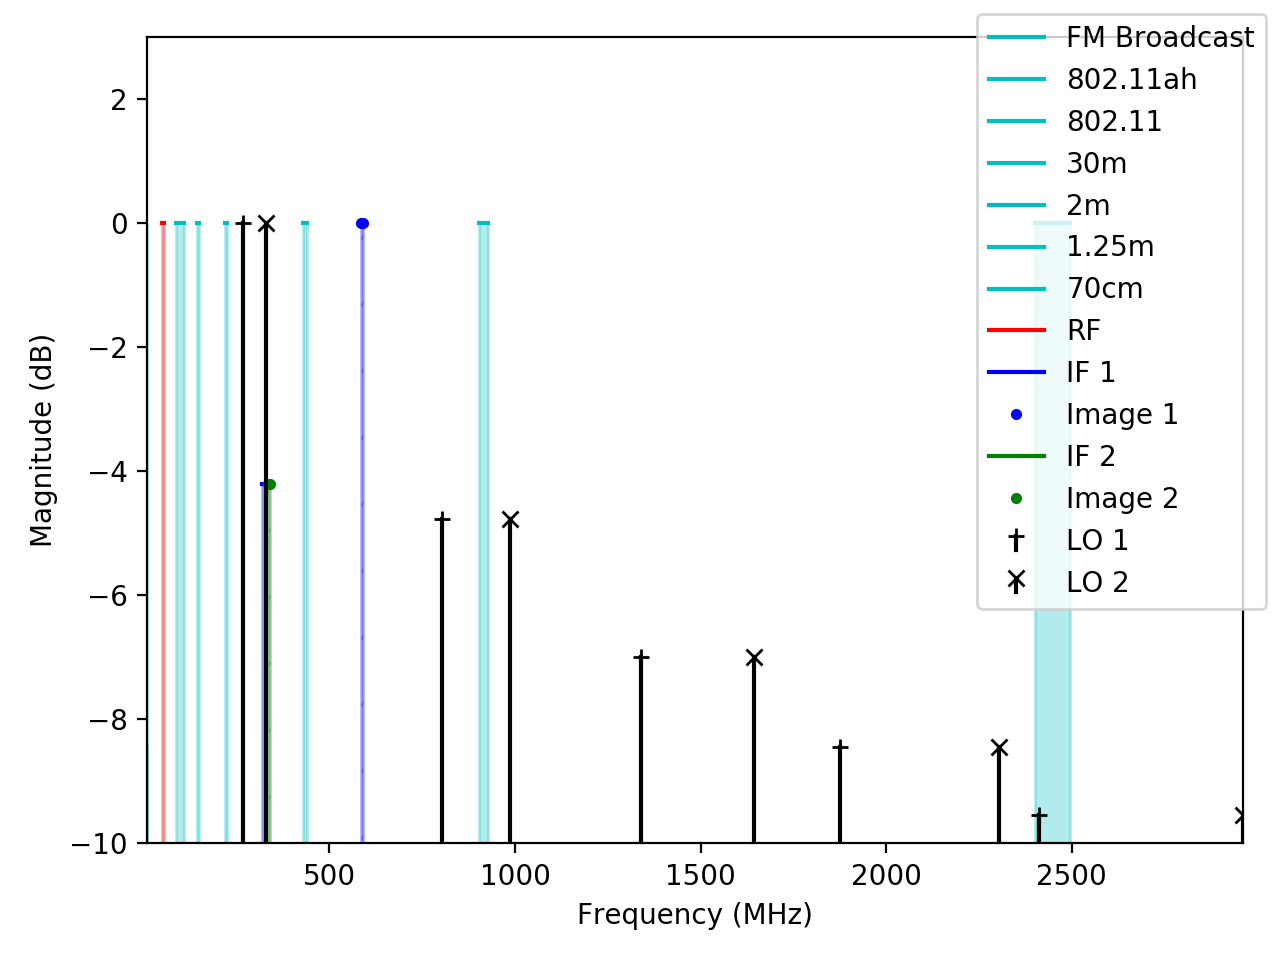

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import plotly.tools
import skrf

fig, ax = plt.subplots()

mag_unit = "dB"
basemag = -150
frequency_resolution = 0.25
max_harmonic = 9
rf_mag = 0

ax.set_xlabel(f"Frequency (MHz)")
_=ax.set_ylabel(f"Magnitude ({mag_unit})")

In [2]:
# just a quick way to adjust the bounds
#lower_bound, upper_bound = 0, 400
ax.set_ylim(top=3, bottom=-10)
#_=ax.set_xlim(left=lower_bound, right=upper_bound)

(-10, 3)

Set some important ranges to avoid. There are some useful ones below that can be uncommented as needed. Mostly active bands to avoid such as GPS, WiFi, etc.

In [3]:
bands_of_interest = {
    'FM Broadcast': skrf.Frequency(88, 108, 2, 'MHz'),
    #'AM Broadcast': skrf.Frequency(0.530, 1.700, 2, 'MHz'),
    '802.11ah': skrf.Frequency(902, 928, 2, 'MHz'),
    '802.11': skrf.Frequency(2401, 2495, 2, 'MHz'),
    #'802.11n': skrf.Frequency(4910, 5875),
    #'Microwave Oven': skrf.Frequency(2430, 2470, 2, 'MHz'),
    '30m': skrf.Frequency(10.1, 10.15, 2, 'MHz'),
    #'20m': skrf.Frequency(14., 14.350, 2, 'MHz'),
    #'17m': skrf.Frequency(18.068, 18.168, 2, 'MHz'),
    #'15m': skrf.Frequency(21., 21.450, 2, 'MHz'),
    #'12m': skrf.Frequency(24.890, 24.990, 2, 'MHz'),
    #'10m': skrf.Frequency(28.0, 29.7, 2, 'MHz'),
    #'6m': skrf.Frequency(50., 54., 2, 'MHz'),
    '2m': skrf.Frequency(144., 148., 2, 'MHz'),
    '1.25m': skrf.Frequency(219., 225., 2, 'MHz'),
    '70cm': skrf.Frequency(430., 440., 2, 'MHz'),
}

for nm, rng in bands_of_interest.items():
    rng.plot(0, 'c-', label=nm)
    ax.fill_between(rng.f, 0, y2=basemag, color='c', alpha=0.3)

Set the input RF frequency range and magnitude. Common magnitudes are 1.0 or normalize multiples or 0.0 for dB relative to RF. If you know absolute power, you can specify dBm but it's rarely useful for this tool.

In [4]:
rf_range = skrf.Frequency(50., 54., 101, 'MHz')
rf_range.plot(rf_mag, 'r-', label='RF')
_=ax.fill_between(rf_range.f, rf_mag, y2=basemag, color="r", alpha=0.3)

Next, specify the IFs. The LO will be calculated and harmonics will be plotted. By default, the harmonics will assume a perfect square wave LO but you can change this if you know the actual performance. If you're just looking for open frequencies, the default should be fine. If you're also designing filters, you might want to better approximate power so you know if you are attenuating enough.

We assume the "out" (RF or previous IF) is a sine wave so we don't calculate harmonics. This is only a possible issue with RF since these will already be calculated for a previous IF. The RF harmonics should also be near fully attenuated by the RF bandpass so it's pretty safe to ignore them for this simple tool.

Also need to calculate the image band and display that for help with filter design.

Sum and difference frequencies will have harmonics since the LO is a square wave. They won't be as close to a square as the LO in most cases but still treat them as such for worst case magnitudes. This completely ignores ever order harmonics in the sum/difference.

if_freq is a Frequency object for the IF at the mixer (i.e. before filtering)

insertion_loss is a subtractive amount for the mixer, typically in dB but the units depend on the rf_mag/base_mag units.

prev_mag is the magnitude of the previous stage (RF or IF)

lo_mag is the magnitude of the local oscillator, usually only matters when using dBm units

out_freq is the Frequency object for in/out frequency (i.e. RF or previous IF not the specified IF) and the filter bandwidth for that ferquency

injection is IF.LOW_SIDE or IF.HIGH_SIDE

In [5]:
class IF:
    LOW_SIDE=-1
    HIGH_SIDE=1
    def __init__(self, if_num, if_freq, out_freq, injection, prev_mag=1., insertion_loss=0., lo_mag=None):
        if lo_mag is None:
            lo_mag = prev_mag
        self.if_num = if_num
        self.frequency = if_freq
        self.out_freq = out_freq
        self.if_mag = prev_mag - insertion_loss
        
        # calculate the local oscillator. The injection parameter identifies this as the desired
        # LO frequency and not the image
        self.lo_injection = injection
        lo_start = np.abs(self.frequency.start + self.lo_injection * self.out_freq.start)
        lo_stop = np.abs(self.frequency.stop + self.lo_injection * self.out_freq.stop)
        self.lo_frequency = skrf.Frequency(lo_start, lo_stop, self.frequency.npoints, 'Hz')
        self.lo_frequency.unit = self.frequency.unit
        self.lo_mag = lo_mag
        
        image_low = self.lo_frequency.start + self.frequency.start
        image_high = self.lo_frequency.stop + self.frequency.stop
        self.image_frequency = skrf.Frequency(image_low, image_high, self.frequency.npoints, 'Hz')
        self.image_frequency.unit = self.frequency.unit
        self.image_mag = prev_mag
        
        # calculate harmonics
        self.lo_harmonics = np.arange(1, max_harmonic + 1, 2) * self.lo_frequency.center
        self.lo_harmonic_mag = 10 * np.log10(1. / np.arange(1, max_harmonic + 1, 2))

    def plot(self, ax, color, harmonic_symbol):
        self.frequency.plot(self.if_mag, color+'-', label=f"IF {self.if_num}")
        ax.fill_between(self.frequency.f, self.if_mag, y2=basemag, color=color, alpha=0.3)
        self.image_frequency.plot(self.image_mag, color+'.', label=f'Image {self.if_num}')
        ax.fill_between(self.image_frequency.f, self.image_mag, y2=basemag, color=color, alpha=0.3, hatch='/')
        ax.stem(self.lo_harmonics, self.lo_harmonic_mag, bottom=basemag,
                markerfmt=harmonic_symbol+'k', basefmt=' ', linefmt='-k', label=f"LO {self.if_num}")
    
    def __str__(self):
        return f"""IF {self.if_num} Frequency: {self.frequency}
IF magnitude: {self.if_mag} {mag_unit}
Injection: {'Low' if self.lo_injection == IF.LOW_SIDE else 'High'} side
Local oscillator: {self.lo_frequency}
Image band: {self.image_frequency}
Harmonics: {self.lo_harmonics}, {self.lo_harmonic_mag}"""

In [6]:
if1 = IF(if_num=1, if_freq=skrf.Frequency(320-rf_range.span_scaled/2., 320+rf_range.span_scaled/2, 2, 'MHz'), out_freq=rf_range, injection=IF.LOW_SIDE, prev_mag=rf_mag, insertion_loss=4.2)
print(if1)
if1.plot(ax, 'b', '+')

IF 1 Frequency: 318.0-322.0 MHz, 2 pts
IF magnitude: -4.2 dB
Injection: Low side
Local oscillator: 268.0-268.0 MHz, 2 pts
Image band: 586.0-590.0 MHz, 2 pts
Harmonics: [2.680e+08 8.040e+08 1.340e+09 1.876e+09 2.412e+09], [ 0.         -4.77121255 -6.98970004 -8.4509804  -9.54242509]


In [7]:
if2 = IF(if_num=2, if_freq=skrf.Frequency(9-(0.027/2), 9+(0.027/2), 2, 'MHz'), out_freq=if1.frequency, injection=IF.HIGH_SIDE, prev_mag=if1.if_mag, insertion_loss=4.2)
print(if2)
if2.plot(ax, 'g', 'x')

IF 2 Frequency: 8.9865-9.0135 MHz, 2 pts
IF magnitude: -8.4 dB
Injection: High side
Local oscillator: 326.9865-331.0135 MHz, 2 pts
Image band: 335.973-340.027 MHz, 2 pts
Harmonics: [3.290e+08 9.870e+08 1.645e+09 2.303e+09 2.961e+09], [ 0.         -4.77121255 -6.98970004 -8.4509804  -9.54242509]


<IPython.core.display.Javascript object>


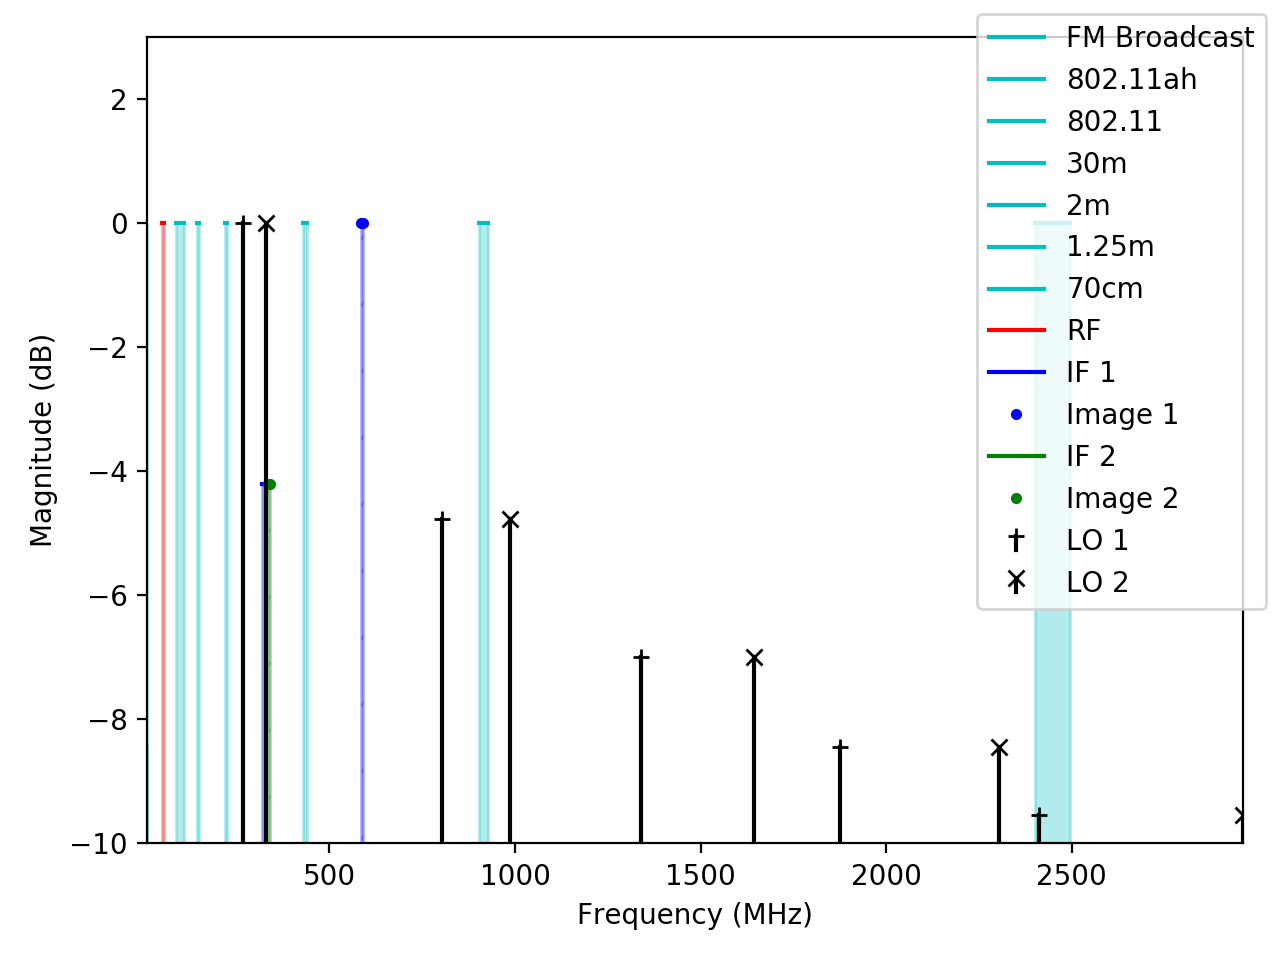

In [8]:
fig.tight_layout()
leg = fig.legend(loc='upper right')
leg.set_alpha(0.6)
fig